In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn import datasets
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, BatchNormalization, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import time
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")

In [2]:
mnist= keras.datasets.mnist
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Label:  4


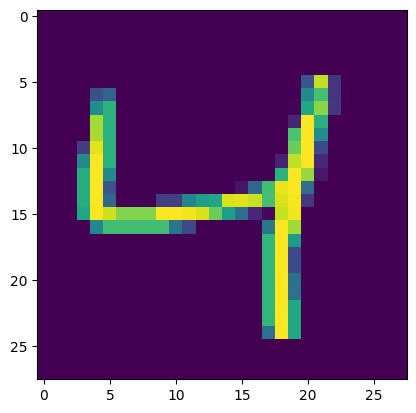

In [3]:
print("Label: ", y_train_full[2])
plt.imshow(X_train_full[2])
plt.show()

In [4]:
print( X_train_full.shape, X_train_full.dtype)

(60000, 28, 28) uint8


In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=1)
X_train.shape, X_val.shape

((48000, 28, 28), (12000, 28, 28))

In [6]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_val = X_val.reshape(X_val.shape[0], 28, 28, 1)
X_train.shape, X_val.shape, X_test.shape

((48000, 28, 28, 1), (12000, 28, 28, 1), (10000, 28, 28, 1))

Label:  4


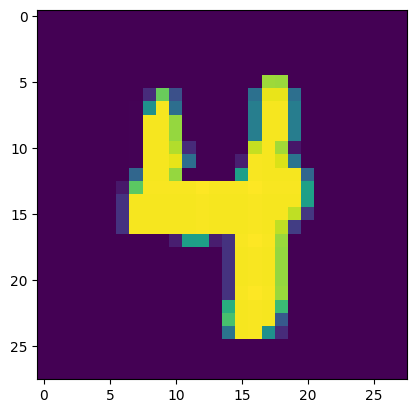

In [7]:
print("Label: ", y_train[2])
plt.imshow(X_train[2])
plt.show()
#essentialy plt gets confused if theres any channel even if it 1

In [8]:
codings_size = 30
generator = keras.models.Sequential([
 keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
 keras.layers.Dense(150, activation="selu"),
 keras.layers.Dense(28 * 28, activation="sigmoid"),
 keras.layers.Reshape([28, 28, 1])
])
generator.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [9]:
def show(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1) #to prevent that confusion
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")


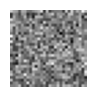

In [10]:
noise = tf.random.normal(shape=[1, codings_size])
generated_images = generator(noise, training=False)
show(generated_images,1)

In [11]:
discriminator = keras.models.Sequential([
 keras.layers.Flatten(input_shape=[28, 28, 1]),
 keras.layers.Dense(150, activation="selu"),
 keras.layers.Dense(100, activation="selu"),
 keras.layers.Dense(1, activation="sigmoid")
])

decision = discriminator(generated_images)    #discriminator hasnt been trained yet so how am i getting a perticular value?????
print(decision)

tf.Tensor([[0.16284555]], shape=(1, 1), dtype=float32)


In [12]:
gan = keras.models.Sequential([generator, discriminator])

In [13]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")    #how come we dont hv to compile the generator? is it cuz until after the first loop,
                                                                  #the generator really has nothing to go on

In [14]:
batch_size = 300
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1) #exp
print(dataset)

<_PrefetchDataset element_spec=TensorSpec(shape=(300, 28, 28, 1), dtype=tf.uint8, name=None)>


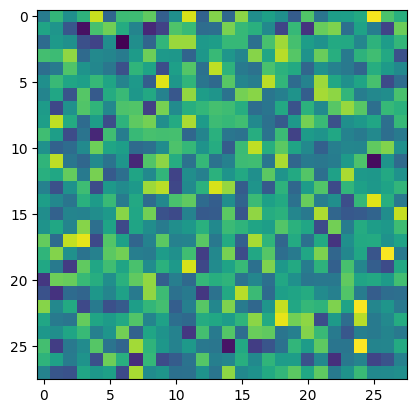

In [15]:
noise=tf.random.normal(shape=[batch_size, codings_size])
gi= generator(noise)
plt.imshow(gi[299])

In [20]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_batch = (tf.cast(X_batch, tf.float32))/255.0 ##what does cast exactly mean here
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size) ##why is constant here
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)


train_gan(gan, dataset, batch_size, codings_size, 10) # on GPU it will take around 3.5 minutes

tf.Tensor(
[[ 0.9619307   1.141586    0.6846602  ... -0.6376793  -0.25660792
   1.3382652 ]
 [-1.2816323  -0.5559831  -1.1076893  ...  0.2009885   0.5838226
   0.4444372 ]
 [-2.0903025  -0.5428737  -1.1864624  ... -0.37923202  0.98887074
   0.27635297]
 ...
 [-0.5669305  -0.59113127 -0.5676381  ...  0.7603557   1.1911662
   0.9213939 ]
 [ 0.40200475  1.8963346  -0.82737297 ...  1.0041202   0.63743085
   0.9055692 ]
 [ 0.18007672  1.6673282  -0.1602077  ... -1.7900983   0.80663204
   0.6061191 ]], shape=(300, 30), dtype=float32)


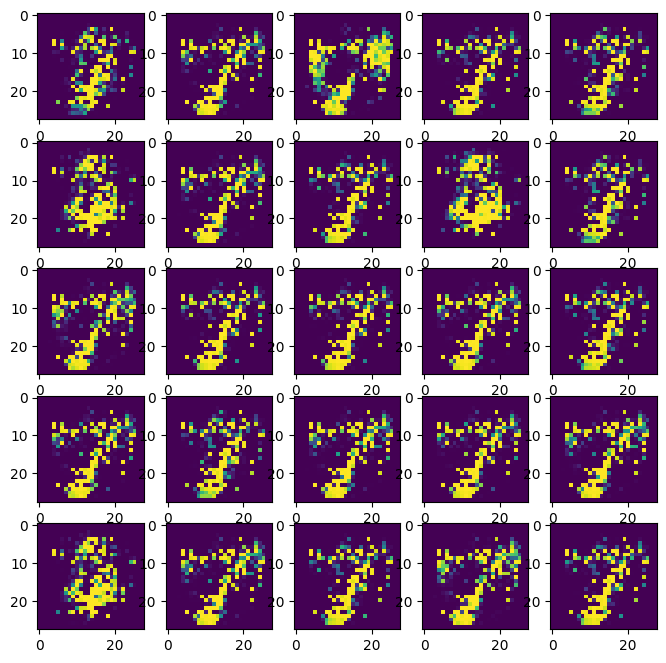

In [27]:
noise=tf.random.normal(shape=[batch_size, codings_size])
print(noise)
gi= generator(noise)

fig = plt.figure(figsize=(8, 8))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i) #?
    plt.imshow(gi[i])
plt.show()

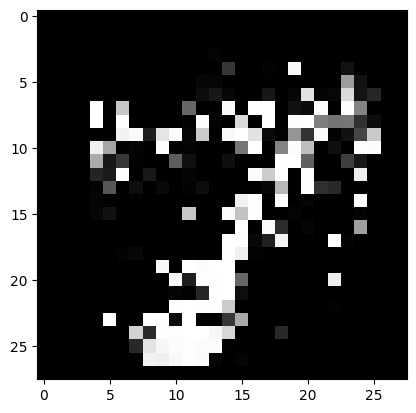

In [22]:
noise2=tf.random.normal(shape=[batch_size, codings_size])
gi2= generator(noise2)
plt.imshow(gi2[50], cmap="gray")

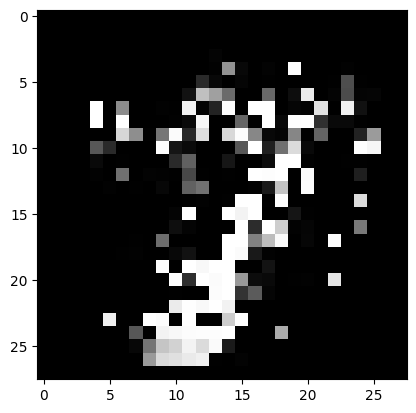

In [23]:
plt.imshow(gi[100], cmap= "gray")